# CASES5-01
## Basic model
This is the basic model for CASES. It is a discrete-time model, but is derived from an ODE. Working in discrete time, however, yields greater flexibility, greater coding flexibility, and is simply easier to understand. The derivation is somewhat lengthy, but the final form given here is quite easy to understand.

<span style="color:blue">Employment(t+1) = function of(Employment(t), intra-industry commerce, inter-industry demand, inter-industry supply)</span>

$$
E_i(t+1) = E_i(t)\left[\left[\alpha_i(1+\Delta_i(t))\frac{E_i(t)}{E_i(0)}\right] + \sum\left[\frac{(1+\Delta_j(t))(\beta_{ij}+\gamma_{ij})E_j(t)}{E_j(0)}\right] \right]
$$
where $E_i(t)$ is employment at time $t$, $\alpha$ is the per capita labour value of intra-industry commerce, $\beta_{ij}$ and $\gamma_{ij}$ are the values of inter-industry exchanges (supply and demand), and $E(0)$ is the initial level of sector employment. $\Delta$ is the sum of the driving parameters, i.e. hiring/firing, mortality, and hospitalization. Additionally, unemployment is
$$
U_i(t+1) = \delta_i(t)U_i(t) + \left[E_i(t)-E_i(t+1)\right]
$$
$\delta$ is the mortality rate.

The following examples currently use the LA dataset. Mortality and hospitalizations rates are considered to be zero.

In [2]:
using StatsPlots, DelimitedFiles, CSV, Plots, DataFrames
# reading a delimited file
I = readdlm("US_exchanges_2018c.csv")

15×15 Array{Float64,2}:
 1.28153    0.0135159  0.00773    …  0.0156276  0.0094602  0.0146184
 0.0372335  1.11834    0.093211      0.0151296  0.0138087  0.0268551
 0.0184729  0.0166119  1.04222       0.021795   0.008112   0.0099787
 0.0120597  0.012506   0.0193105     0.0076677  0.0087455  0.0287984
 0.387082   0.236255   0.134891      0.1598     0.159384   0.223719
 0.150443   0.0526213  0.03145    …  0.0374893  0.0335185  0.0431247
 0.0083378  0.0036551  0.0075759     0.0077494  0.012921   0.0033437
 0.0681456  0.0521195  0.0750681     0.0267532  0.0229341  0.0362094
 0.0195425  0.0257214  0.0222736     0.0384731  0.0409086  0.0452146
 0.186783   0.136408   0.0748774     0.165861   0.157982   0.0864993
 0.0992767  0.169228   0.114341   …  0.194094   0.129072   0.126296
 0.0005429  0.0003333  0.0007803     0.0017449  0.0048802  0.0079003
 0.0088715  0.0086924  0.0105185     1.03519    0.0162784  0.0114603
 0.0092786  0.0070565  0.0051895     0.0163076  1.01573    0.0135882
 0.0222345  

In [3]:
# load dataset
employed = CSV.read("LA_employment_by_sector_2020.csv")

┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `DataFrame!(CSV.File(input; kw...))`
└ @ CSV /Users/joe/.julia/packages/CSV/hZ1pV/src/CSV.jl:40


,Sector,Jan,Feb,Mar,Apr,May,Jan_Feb
,String,Int64,Int64,Int64,Int64,Int64,Float64
1,Total farm,4300,4400,4200,3800,3700,-0.000232558
2,Mining and logging,1900,1900,1900,1900,2000,0.0
3,Utilities,12200,12200,12200,12300,12300,0.0
4,Construction,151400,152600,148900,130900,143100,-7.92602e-5
5,Manufacturing,335800,336600,328900,291400,306700,-2.38237e-5
6,Wholesale trade,218200,218700,217000,196200,204200,-2.29148e-5
7,Retail trade,420900,415800,413800,339600,341700,0.000121169
8,Transportation and warehousing,207500,205800,203700,185500,183700,8.19277e-5
9,Information,227500,241000,234300,183400,174400,-0.000593407


In [4]:
no_sectors = size(I,1)

# beta and gamma matrices
A = Array{Float64}(undef,no_sectors,no_sectors)
B = Array{Float64}(undef,no_sectors,no_sectors)
C = Array{Float64}(undef,no_sectors,no_sectors)
abc = Float64[]
for i = 1:no_sectors
    row_sum = 0.0
    for j = 1:no_sectors
        row_sum = row_sum +I[i,j] + I[j,i]
    end
    row_sum = row_sum - I[i,i]
    push!(abc,row_sum)
end
#print(abc)

        
for i = 1:no_sectors
    #abc = sum(I[:,1])+sum(I[1,:])-(I[1,1])
    for j = 1:no_sectors
        A[i,j] = 0.0
        B[i,j] = I[j,i]/abc[i]
        C[i,j] = I[i,j]/abc[i]
    end
    A[i,i] = I[i,i]/abc[i]
    B[i,i] = 0.0
    C[i,i] = 0.0
end

The following simulation is based on employment changes between February and March (almost all negative). If you examine the code, you will see several places where months are entered as <span style="color:blue">:month</span>. Changing those will allow you to simulate any time interval.

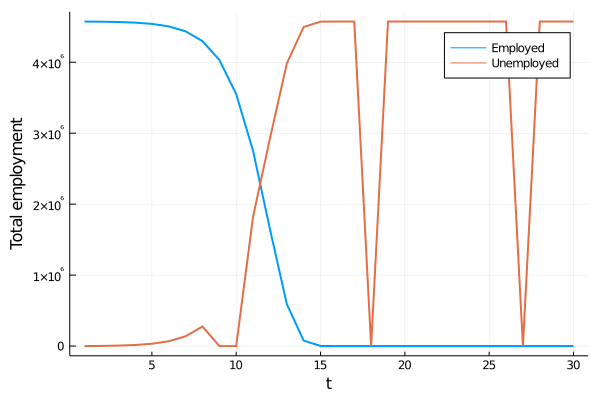

In [5]:
# parameter array
p = Array{Float64}(undef,no_sectors,3)
for i = 1:no_sectors
    p[i,1] = (employed[i,:Mar] - employed[i,:Feb])/(employed[i,:Feb]*30)
    p[i,2] = 0.0
    p[i,3] = 0.0
end

# perturbation
D = Float64[]
for i = 1:no_sectors
    push!(D,p[i,1]+p[i,2]+p[i,3])
end
#print(D)

# time
T = 30

# employment
E = Array{Float64}(undef,T,no_sectors+1)
U = Array{Float64}(undef,T,no_sectors+1)
# initial conditions
for i = 1:no_sectors
    E[1,1] = 1.0
    E[1,i+1] = employed[i,:Mar]
    U[1,1] = 1.0
    U[1,i+1] = 0.0
end

# simulate
for i = 2:T
    E[i,1] = convert(Float64,i)
    for j = 1:no_sectors
        alpha = A[j,j]*(1.0+D[j])*E[i-1,j+1]/E[1,j+1]
        #println(alpha)
        beta = 0.0
        for k = 1:no_sectors
            beta = beta + ((1.0+D[k])*(B[j,k]+C[j,k])*(E[i-1,k+1]/E[1,k+1]))
        end
        #println(beta)
        a = alpha+beta
        #println(a)
        # modify E and U
        if a-1.0 >= 0 # positive growth
            del_E = round(a*(E[i-1,j+1]) - E[i-1,j+1])
            #println(del_E)
            if del_E <= U[i-1,j+1] # if re-hiring possible
                E[i,j+1] = round(a*E[i-1,j+1]) #+ del_E
                U[i,j+1] = round((U[i-1,j+1]*(1-p[2])) + ((E[i-1,j+1]-E[i,j+1])))*(1-p[2])
            elseif del_E > U[i-1,j+1]
                E[i,j+1] = E[i-1,j+1] + U[i-1,j+1]
                U[i,j+1] = 0.0
            end
        elseif a-1.0 < 0 # negative growth
            del_E = E[i-1,j+1] - round(a*(E[i-1,j+1]))
            E[i,j+1] = round(a*(E[i-1,j+1]))
            U[i,j+1] = U[i-1,j+1]*(1-p[2]) + (E[i-1,j+1]-E[i,j+1])
        end
        # no negative unemployment
        if U[i,j+1] < 0.0
            U[i,j+1] = 0.0
        end
        if U[i,j+1] >= E[1,j+1]
            U[i,j+1] = E[1,j+1]
        end
    end
end
#print(E)

# plot
e = Float64[]
u = Float64[]
for i = 1:T
    push!(e,sum(E[i,:])-E[i,1])
    push!(u,sum(U[i,:])-U[i,1])
end
plot(e,xlabel="t",ylabel="Total employment",label="Employed",lw=2)
plot!(u,label="Unemployed",lw=2)

"Time" cannot be read literally as "days", but is instead an unspecified model time. A proper interpretation of time must be made relative to other model results. The conclusion here is that the system begins to decline slowly, almost immediately, but decline accelerates rapidly until complete collapse is reached.

## Some experiments
### Sector independence
What is the relative importance of intra- versus inter-industry links? We can assess this by simply setting the $\beta$ and $\gamma$ coefficients to zero, effectively ending inter-industry exchanges. This is an unrealistic scenario of course, as the sectors are simply categorizations of a multitude of economic activities, but it is insightful. In this case, the basic model reduces to
$$
E_i(t+1) = E_i(t)(1+\Delta(i))\frac{E_i(t)}{E_i(0)} = \frac{E_i^2(t)(1+\Delta_i(t))}{E_i(0)}
$$

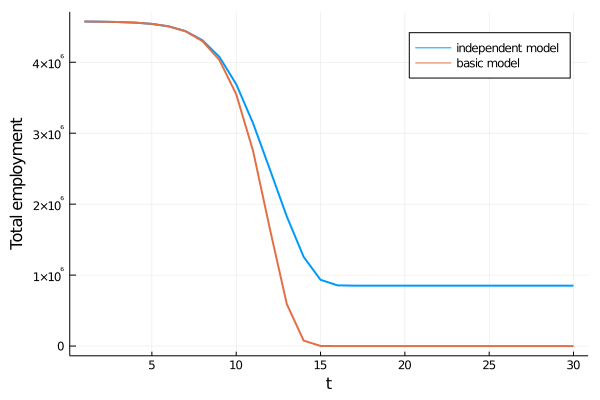

In [6]:
# parameter array
p = Array{Float64}(undef,no_sectors,3)
for i = 1:no_sectors
    p[i,1] = (employed[i,:Mar] - employed[i,:Feb])/(employed[i,:Feb]*30)
    #p[i,1] = 0.1
    p[i,2] = 0.0
    p[i,3] = 0.0
end

# perturbation
D = Float64[]
for i = 1:no_sectors
    push!(D,p[i,1]+p[i,2]+p[i,3])
end
#print(D)

Ei = Array{Float64}(undef,T,no_sectors+1)
Ui = Array{Float64}(undef,T,no_sectors+1)
# initial conditions
for i = 1:no_sectors
    Ei[1,1] = 1.0
    Ei[1,i+1] = employed[i,:Mar]
    Ui[1,1] = 1.0
    Ui[1,i+1] = 0.0
end
for i = 2:T
    Ei[i,1] = convert(Float64,i)
    for j = 1:no_sectors
        alpha = (Ei[i-1,j+1])*(1.0+D[j])/Ei[1,j+1]
        a = alpha
        #println(a)
        # modify E and U
        if a-1.0 >= 0 # positive growth
            del_E = round(a*(Ei[i-1,j+1]) - Ei[i-1,j+1])
            #println(del_E)
            if del_E <= Ui[i-1,j+1] # if re-hiring possible
                Ei[i,j+1] = round(a*Ei[i-1,j+1]) #+ del_E
                Ui[i,j+1] = round((Ui[i-1,j+1]*(1-p[2])) + (Ei[i-1,j+1]-Ei[i,j+1]))
            elseif del_E > Ui[i-1,j+1]
                Ei[i,j+1] = Ei[i-1,j+1] + Ui[i-1,j+1]
                Ui[i,j+1] = 0.0
            end
        elseif a-1.0 < 0 # negative growth
            del_E = Ei[i-1,j+1] - round(a*(Ei[i-1,j+1]))
            Ei[i,j+1] = round(a*(Ei[i-1,j+1]))
            Ui[i,j+1] = Ui[i-1,j+1]*(1-p[2]) + (Ei[i-1,j+1]-Ei[i,j+1])
        end
        # no negative unemployment
        if Ui[i,j+1] < 0.0
            Ui[i,j+1] = 0.0
        end
        if Ui[i,j+1] >= Ei[1,j+1]
            Ui[i,j+1] = Ei[1,j+1]
        end
    end
end
#print(E)

# plot
ei = Float64[]
ui = Float64[]
for i = 1:T
    push!(ei,sum(Ei[i,:])-Ei[i,1])
    push!(ui,sum(Ui[i,:])-Ui[i,1])
end
plot(ei,xlabel="t",ylabel="Total employment",label="independent model",lw=2)
plot!(e,lw=2,label="basic model")

You can see the magnitude of inter-industry links. Those are what cause the system to collapse, i.e. employment losses across sectors affect the entire system. Note, however, that very early in time that the original system (red) declines more slowly. This effect becomes more pronounced the milder the job loss rates (e.g. between January and February). Therefore, under "normal" circumstances, inter-industry exchanges actually buffer the system against decline. But the two systems exchange those relative positions as time goes on, with inter-industry links becoming a greater liability. I would suggest that under most circumstances we are operating at relatively mild firing/hiring rates, and also that economic cycles operate at frequencies that are high enough that one rarely gets very far along the time axis before parameters change again, e.g. recession/expansion cycles.

### Sector impact
What are the relative impacts of different sectors? Are some sectors more important to SES dynamics than others? One would expect that sectors that have stronger interactions would also have greater impact. The next two simulations will compare two sectors, where for each simulation only one sector experiences losses. We will compare Wholesale trade, and Leisure and Hospitality. The former is generally understood to be fundamental to the system, but the latter was affected most severely by California's shelter-in-place (SIP) order, losing jobs at almost 3 times the rate of Wholesale trade.

In [7]:
# parameter array
p = Array{Float64}(undef,no_sectors,3)
for i = 1:no_sectors
    p[i,1] = 0.0
    if employed[i,:Sector]=="Wholesale trade"
        p[i,1] = (employed[i,:Mar] - employed[i,:Feb])/(employed[i,:Feb]*30)
       # p[i,1] = -0.0002
    end
    p[i,2] = 0.0
    p[i,3] = 0.0
end

# perturbation
Dm = Float64[]
for i = 1:no_sectors
    push!(Dm,p[i,1]+p[i,2]+p[i,3])
end
print(Dm)

# time
T = 30

# employment
Em = Array{Float64}(undef,T,no_sectors+1)
Um = Array{Float64}(undef,T,no_sectors+1)
# initial conditions
for i = 1:no_sectors
    Em[1,1] = 1.0
    Em[1,i+1] = employed[i,:Mar]
    Um[1,1] = 1.0
    Um[1,i+1] = 0.0
end

# simulate
for i = 2:T
    Em[i,1] = convert(Float64,i)
    for j = 1:no_sectors
        alpha = A[j,j]*(1.0+Dm[j])*Em[i-1,j+1]/Em[1,j+1]
        #println(alpha)
        beta = 0.0
        for k = 1:no_sectors
            beta = beta + ((1.0+Dm[k])*(B[j,k]+C[j,k])*(Em[i-1,k+1]/Em[1,k+1]))
        end
        #println(beta)
        a = alpha+beta
        #println(a)
        # modify E and U
        if a-1.0 >= 0 # positive growth
            del_E = round(a*(Em[i-1,j+1]) - Em[i-1,j+1])
            #println(del_E)
            if del_E <= Um[i-1,j+1] # if re-hiring possible
                Em[i,j+1] = round(a*Em[i-1,j+1]) #+ del_E
                Um[i,j+1] = round((Um[i-1,j+1]*(1-p[2])) + ((Em[i-1,j+1]-Em[i,j+1])))*(1-p[2])
            elseif del_E > Um[i-1,j+1]
                Em[i,j+1] = Em[i-1,j+1] + Um[i-1,j+1]
                Um[i,j+1] = 0.0
            end
        elseif a-1.0 < 0 # negative growth
            del_E = Em[i-1,j+1] - round(a*(Em[i-1,j+1]))
            Em[i,j+1] = round(a*(Em[i-1,j+1]))
            Um[i,j+1] = Um[i-1,j+1]*(1-p[2]) + (Em[i-1,j+1]-Em[i,j+1])
        end
        # no negative unemployment
        if Um[i,j+1] < 0.0
            Um[i,j+1] = 0.0
        end
        if Um[i,j+1] >= Em[1,j+1]
            Um[i,j+1] = Em[1,j+1]
        end
    end
end
#print(E)

# plot
em = Float64[]
um = Float64[]
for i = 1:T
    push!(em,sum(Em[i,:])-Em[i,1])
    push!(um,sum(Um[i,:])-Um[i,1])
end
#plot(em,xlabel="t",ylabel="Total employment",label="Employed",lw=2)
#plot!(um,label="Unemployed",lw=2)

[0.0, 0.0, 0.0, 0.0, 0.0, -0.0002591068434689834, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [9]:
# parameter array
p = Array{Float64}(undef,no_sectors,3)
for i = 1:no_sectors
    p[i,1] = 0.0
    if employed[i,:Sector]=="Leisure and hospitality"
        p[i,1] = (employed[i,:Mar] - employed[i,:Feb])/(employed[i,:Feb]*30)
        #p[i,1] = -0.0002
    end
    p[i,2] = 0.0
    p[i,3] = 0.0
end

# perturbation
Dl = Float64[]
for i = 1:no_sectors
    push!(Dl,p[i,1]+p[i,2]+p[i,3])
end
print(Dl)

# time
T = 30

# employment
El = Array{Float64}(undef,T,no_sectors+1)
Ul = Array{Float64}(undef,T,no_sectors+1)
# initial conditions
for i = 1:no_sectors
    El[1,1] = 1.0
    El[1,i+1] = employed[i,:Mar]
    Ul[1,1] = 1.0
    Ul[1,i+1] = 0.0
end

# simulate
for i = 2:T
    El[i,1] = convert(Float64,i)
    for j = 1:no_sectors
        alpha = A[j,j]*(1.0+Dl[j])*El[i-1,j+1]/El[1,j+1]
        #println(alpha)
        beta = 0.0
        for k = 1:no_sectors
            beta = beta + ((1.0+Dl[k])*(B[j,k]+C[j,k])*(El[i-1,k+1]/El[1,k+1]))
        end
        #println(beta)
        a = alpha+beta
        #println(a)
        # modify E and U
        if a-1.0 >= 0 # positive growth
            del_E = round(a*(El[i-1,j+1]) - El[i-1,j+1])
            #println(del_E)
            if del_E <= Ul[i-1,j+1] # if re-hiring possible
                El[i,j+1] = round(a*El[i-1,j+1]) #+ del_E
                Ul[i,j+1] = round((Ul[i-1,j+1]*(1-p[2])) + ((El[i-1,j+1]-El[i,j+1])))*(1-p[2])
            elseif del_E > Ul[i-1,j+1]
                El[i,j+1] = El[i-1,j+1] + Ul[i-1,j+1]
                Ul[i,j+1] = 0.0
            end
        elseif a-1.0 < 0 # negative growth
            del_E = El[i-1,j+1] - round(a*(El[i-1,j+1]))
            El[i,j+1] = round(a*(El[i-1,j+1]))
            Ul[i,j+1] = Ul[i-1,j+1]*(1-p[2]) + (El[i-1,j+1]-El[i,j+1])
        end
        # no negative unemployment
        if Ul[i,j+1] < 0.0
            Ul[i,j+1] = 0.0
        end
        if Ul[i,j+1] >= El[1,j+1]
            Ul[i,j+1] = El[1,j+1]
        end
    end
end
#print(E)

# plot
el = Float64[]
ul = Float64[]
for i = 1:T
    push!(el,sum(El[i,:])-El[i,1])
    push!(ul,sum(Ul[i,:])-Ul[i,1])
end
#plot(el,xlabel="t",ylabel="Total employment",label="Employed",lw=2)
#plot!(ul,label="Unemployed",lw=2)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0015878854760591012, 0.0, 0.0]

In [13]:
print(em)

[4.5736e6, 4.573537e6, 4.573407e6, 4.573147e6, 4.572629e6, 4.571603e6, 4.569557e6, 4.565489e6, 4.55737e6, 4.541203e6, 4.509083e6, 4.445584e6, 4.321325e6, 4.083233e6, 3.645874e6, 2.906931e6, 1.84827e6, 747387.0, 122266.0, 3275.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

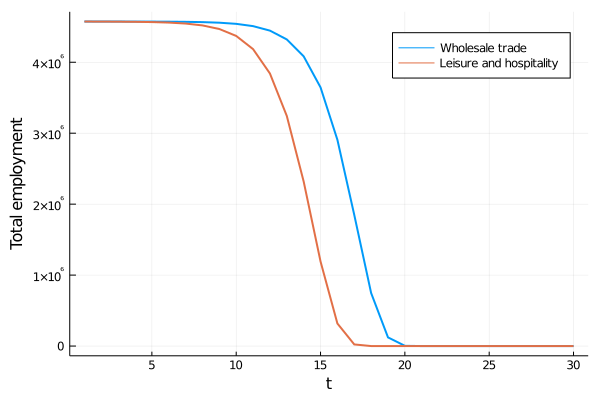

In [12]:
plot(em,xlabel="t",ylabel="Total employment",label="Wholesale trade",lw=2)
plot!(el,lw=2,label="Leisure and hospitality")

In spite of its stronger connections, Wholesale trade has less impact on the system. This has to be because of the more severe job loss rate in Leisure. Thus, the parameter rates drive this system, with significantly less input from sector sizes, and even the link strengths between sectors. This is a very tightly integrated system with little flexibility.

The tight integration is probably beneficial during good times, as exchanges are highly efficient and distributed throughout the system; everybody benefits. But it might also be a liability entering a recession, because similarly everyone is affected even if some sectors are more strongly driven than others. Also, when attempting to exit a recession, all sectors must likewise be driven. How often have you heard phrases such as "recovery in the manufacturing sector", and maybe wondered why there isn't a corresponding recovery in the retail sector? Because all sectors must be involved. The next simulations demonstrate this with recoveries modeled as simple reversals of the job loss parameters. A simple expectation is that the above curves will simple reverse themselves. 

### Recovery
Re-hiring rates are simple reversals of job loss rates, but all rates are positive, i.e. no jobs are being lost anymore.

[-0.045454545454545456, 0.0, 0.0, -0.024246395806028834, -0.02287581699346405, -0.007773205304069501, -0.00481000481000481, -0.01020408163265306, -0.02780082987551867, 0.0, -0.005249343832020997, -0.007860362963819211, -0.047636564281773035, -0.056214865708931916, 0.0]

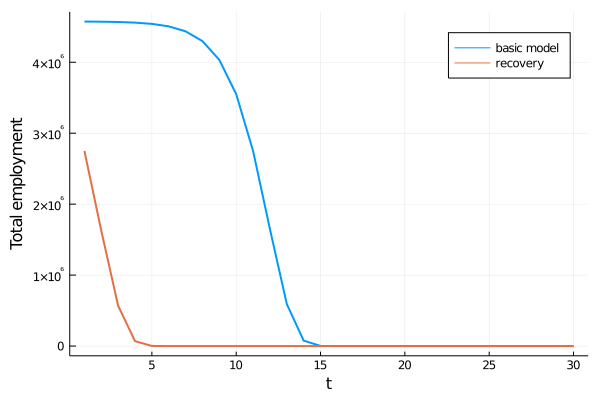

In [14]:
# parameter array
# reverse signs of previous parameter values
p = Array{Float64}(undef,no_sectors,3)
for i = 1:no_sectors
    #p[i,1] = 36.18*abs(employed[i,:Feb] - employed[i,:Jan])/(employed[i,:Jan]*1)
    p[i,1] = 1*(employed[i,:Mar] - employed[i,:Feb])/(employed[i,:Feb]*1)
    if p[i,1] > 0
        p[i,1] = 0.0
    end
    p[i,2] = 0.0
    p[i,3] = 0.0
end

# perturbation
D = Float64[]
for i = 1:no_sectors
    push!(D,p[i,1]+p[i,2]+p[i,3])
end
print(D)

# time
T = 30

# employment
E2 = Array{Float64}(undef,T,no_sectors+1)
U2 = Array{Float64}(undef,T,no_sectors+1)
# initial conditions
# reverse time
# use Day xx from previous simulation
for i = 1:no_sectors
    E2[1,1] = 11.0
    E2[1,i+1] = E[11,i+1]
    U2[1,1] = 11.0
    U2[1,i+1] = U[10,i+1]
end

# simulate
for i = 2:T
    E2[i,1] = 12.0 - convert(Float64,i)
    U2[i,1] = 12.0 - convert(Float64,i)
    for j = 1:no_sectors
        alpha = A[j,j]*(1.0+D[j])*E2[i-1,j+1]/E[1,j+1]
        #println(alpha)
        beta = 0.0
        for k = 1:no_sectors
            beta = beta + ((1.0+D[k])*(B[j,k]+C[j,k])*(E2[i-1,k+1]/E[1,k+1]))
        end
        #println(beta)
        a = alpha+beta
        #println(a)
        # modify E and U
        if a-1.0 >= 0 # positive growth
            del_E = round(a*(E2[i-1,j+1]) - E2[i-1,j+1])
            #println(del_E)
            if del_E <= U2[i-1,j+1] # if re-hiring possible
                E2[i,j+1] = round(a*E2[i-1,j+1]) #+ del_E
                U2[i,j+1] = round((U2[i-1,j+1]*(1-p[2])) + ((E2[i-1,j+1]-E2[i,j+1]))*(1-p[2]))
            elseif del_E > U2[i-1,j+1]
                E2[i,j+1] = E2[i-1,j+1] + U2[i-1,j+1]
                U2[i,j+1] = 0.0
            end
        elseif a-1.0 < 0 # negative growth
            del_E = E2[i-1,j+1] - round(a*(E2[i-1,j+1]))
            E2[i,j+1] = round(a*(E2[i-1,j+1]))
            U2[i,j+1] = U2[i-1,j+1]*(1-p[2]) + (E2[i-1,j+1]-E2[i,j+1])
        end
        # no negative unemployment
        if U2[i,j+1] < 0.0
            U2[i,j+1] = 0.0
        end
        if U2[i,j+1] >= E2[1,j+1]
            U2[i,j+1] = E2[1,j+1]
        end
    end
end
#print(E2)

# plot
e2 = Float64[]
u2 = Float64[]
for i = 1:T
    push!(e2,sum(E2[i,:])-E2[i,1])
    push!(u2,sum(U2[i,:])-U2[i,1])
end
plot(e,xlabel="t",ylabel="Total employment",label="basic model",lw=2)
plot!(e2,lw=2,label="recovery")
#plot!(u2)

There is no recovery! The next four simulations elevated the recovery rates by factors of 10, 20, 30 and 40. (Code blocks omitted here, as they are repetitive).

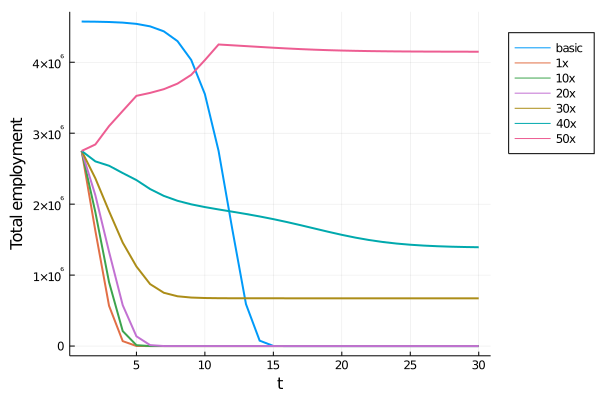

In [15]:
e10 = [2.75013e6, 1.88777e6, 900940.0, 210733.0, 12237.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
e20 = [2.75013e6, 2.12614e6, 1.32929e6, 575468.0, 137368.0, 13120.0, 272.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
e30 = [2.75013e6, 2.36452e6, 1.90067e6, 1.45761e6, 1.1215e6, 872924.0, 751132.0, 701637.0, 683643.0, 677102.0, 674651.0, 673708.0, 673341.0, 673196.0, 673138.0, 673115.0, 673106.0, 673102.0, 673101.0, 673100.0, 673100.0, 673100.0, 673100.0, 673100.0, 673100.0, 673100.0, 673100.0, 673100.0, 673100.0, 673100.0]
e40 = [2.75013e6, 2.6029e6, 2.54134e6, 2.43814e6, 2.33911e6, 2.21278e6, 2.11645e6, 2.04741e6, 1.9975e6, 1.95875e6, 1.92543e6, 1.89382e6, 1.86146e6, 1.82676e6, 1.78882e6, 1.74743e6, 1.7031e6, 1.65705e6, 1.61114e6, 1.56749e6, 1.52807e6, 1.49422e6, 1.46649e6, 1.44468e6, 1.42809e6, 1.41579e6, 1.40685e6, 1.40044e6, 1.39589e6, 1.39267e6]
e50 = [2.75013e6, 2.84127e6, 3.10028e6, 3.31414e6, 3.52637e6, 3.56799e6, 3.6204e6, 3.6988e6, 3.82215e6, 4.03019e6, 4.25022e6, 4.23891e6, 4.22731e6, 4.2159e6, 4.20469e6, 4.19427e6, 4.18496e6, 4.17695e6, 4.17028e6, 4.16487e6, 4.16061e6, 4.15731e6, 4.15479e6, 4.1529e6, 4.15149e6, 4.15044e6, 4.14967e6, 4.14911e6, 4.1487e6, 4.1484e6]
plot(e,xlabel="t",ylabel="Total employment",label="basic",lw=2,leg=:outertopright)
plot!(e2,lw=2,label="1x")
plot!(e10,lw=2,label="10x")
plot!(e20,lw=2,label="20x")
plot!(e30,lw=2,label="30x")
plot!(e40,lw=2,label="40x")
plot!(e50,lw=2,label="50x")

## Pulse perturbation
What if layoffs occurred in a single pulse, in contrast to a consistent rate? In the next simulation, all Feb.-Mar. layoffs occur on day 2, with no further layoffs. The system is nevertheless destabilized and collapses.

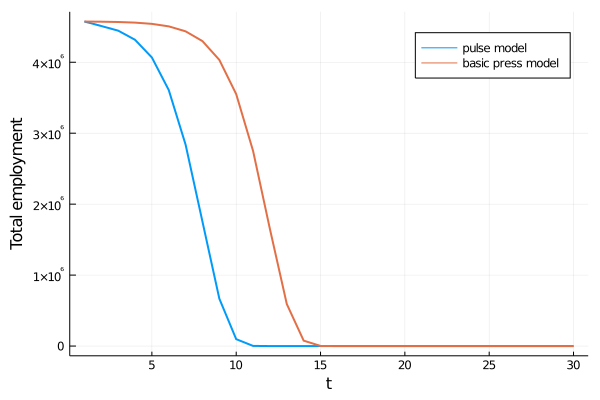

In [17]:
# time
T = 30

# parameter array
# add column vector for time
p = Array{Float64}(undef,T,no_sectors,3)
for i = 1:T
    #p[i,no_sectors+1] = i
    for j = 1:no_sectors
        p[i,j,1] = 0.0
        # no perturbation except when t=2
        if i == 2
            p[i,j,1] = (employed[j,:Mar] - employed[j,:Feb])/(employed[j,:Feb]*1)
        end
        p[i,j,2] = 0.0
        p[i,j,3] = 0.0
    end
end

# perturbation
D = Array{Float64}(undef,T,no_sectors)
for i = 1:T
    for j = 1:no_sectors
        D[i,j] = p[i,j,1]+p[i,j,2]+p[i,j,3]
    end
end
#print(D)

# employment
Ep = Array{Float64}(undef,T,no_sectors+1)
Up = Array{Float64}(undef,T,no_sectors+1)
# initial conditions
for i = 1:no_sectors
    Ep[1,1] = 1.0
    Ep[1,i+1] = employed[i,:Mar]
    Up[1,1] = 1.0
    Up[1,i+1] = 0.0
end

# simulate
for i = 2:T
    Ep[i,1] = convert(Float64,i)
    for j = 1:no_sectors
        alpha = A[j,j]*(1.0+D[i,j])*Ep[i-1,j+1]/Ep[1,j+1]
        #println(alpha)
        beta = 0.0
        for k = 1:no_sectors
            beta = beta + ((1.0+D[i,k])*(B[j,k]+C[j,k])*(Ep[i-1,k+1]/Ep[1,k+1]))
        end
        #println(beta)
        a = alpha+beta
        #println(a)
        # modify E and U
        if a-1.0 >= 0 # positive growth
            del_E = round(a*(Ep[i-1,j+1]) - Ep[i-1,j+1])
            #println(del_E)
            if del_E <= Up[i-1,j+1] # if re-hiring possible
                Ep[i,j+1] = round(a*Ep[i-1,j+1]) #+ del_E
                Up[i,j+1] = round((Up[i-1,j+1]*(1-p[2])) + ((Ep[i-1,j+1]-Ep[i,j+1])))*(1-p[2])
            elseif del_E > Up[i-1,j+1]
                Ep[i,j+1] = Ep[i-1,j+1] + Up[i-1,j+1]
                Up[i,j+1] = 0.0
            end
        elseif a-1.0 < 0 # negative growth
            del_E = Ep[i-1,j+1] - round(a*(Ep[i-1,j+1]))
            Ep[i,j+1] = round(a*(Ep[i-1,j+1]))
            Up[i,j+1] = Up[i-1,j+1]*(1-p[2]) + (Ep[i-1,j+1]-Ep[i,j+1])
        end
        # no negative unemployment
        if Up[i,j+1] < 0.0
            Up[i,j+1] = 0.0
        end
        if Up[i,j+1] >= Ep[1,j+1]
            Up[i,j+1] = Ep[1,j+1]
        end
    end
end
#print(E)

# plot
ep = Float64[]
up = Float64[]
for i = 1:T
    push!(ep,sum(Ep[i,:])-Ep[i,1])
    push!(up,sum(Up[i,:])-Up[i,1])
end
plot(ep,xlabel="t",ylabel="Total employment",label="pulse model",lw=2)
plot!(e,label="basic press model",lw=2)

Is there a threshold below which collapse is avoided?

## Next steps
### Maps
General maps to be created, simulating the system over parameter ranges. 
1. Firing rate ($-\lambda$) vs. time, i.e. simply simulating the basic model over a range of firing rates, ranging from the lowest to highest sector rates observed in California.
2. A recovery map, of $-\lambda$ vs. $+\lambda$. The objectives will be to discover when recovery is possible, the extent to which recovery can occur, and to demonstrate the hysteresis of the system, i.e. that at some level re-hiring rates must greatly exceed the original firing rates.

### Shutdown scenarios
The original goal of the shelter-in-place (SIP) order in California was to flatten the COVID-19 infection curve. The idea is a 4 week interruption which presumably allows all new infections to reveal themselves, and ongoing infections to be resolved. There are of course many complications with this approach, including its reliance on effective testing (absent in the United States until very very recently). But the mechanism is sound, as it attacks the first two steps in an epidemic chain, the probability of contact between and infectious person and a susceptible, and the probability of infection occurring during such an encounter. SIP, in theory, affects the probability of both. The first economic problem is that implementation of a SIP order then either requires compliance by workers by physically separating them from the workplace, or the order renders certain businesses unviable because they require clients to be physically present, or both. The second problem is industry reacts pre-emptively, anticipating the consequences of the first problem, and hoarding cash by shedding workers, either through layoffs or furloughs. Those actions propagate through the system, as captured simplistically by the results above. The overall situation is further complicated by the overall failure to control the disease, which in turns leads to pressure to undo the SIP and "re-open" the economy, thereby perpetuating the pandemic's socio-economic stress. And everything is greatly complicated by the inability of the average American to understand the fundamentals of personal and societal survival. There is a lot of talk of the need to balance the health and economic emergencies, but I have seen very little action in this country to actually do so. So, the question posed here is, are there ways to more intelligently implement SIP orders that will serve to both alter epidemic dynamics and lessen impact on the economy? And before we get into possible ideas, I will note that I am firmly convinced that any such solutions would require two things: Compliance with SIP and shutdown orders, and the periodic injection of significant amounts of government funds into the economy. Here are some ideas, very preliminary, currently untested, and open to criticism.

Selective sector shutdowns. SIP requires the shutdown of businesses essential to disrupting infection probabilities, hence the huge hit taken by Leisure and Hospitality even before the California state of emeregency or SIP declarations. Furthermore the California version of the WARN Act requires businesses to file a 60 day notice of layoffs, but that was suspended in response to COVID-19. I believe that was huge mistake. There are other sectors, such as Financial, full of businesses capable of effective operation during a SIP. A sector such as Manufacturing would be intermediate. Therefore, given the COVID-19 situation in early March, how much transmission disruption was required, what would be the minimum number of isolated persons dictated by the disease dynamics, and how could that be accomplished by selective withdrawals from individual sectors? The economy would of course begin to slide toward collapse, but then we ask, how much support would be required for a pulsed return of workers intended to stimulate a recovery, and how quickly could that be accomplished?

Rolling shutdowns and re-opening. There isn't anything inherently wrong with desiring a re-opening of the economy. What is lacking is intelligence. Re-opening under current conditions results in both persistence and resurgence of the disease, and repeats of the chaotic shutdowns of several weeks ago. Again, any shutdowns could be done intelligently to respond to the actual dynamics of the epidemic, and re-openings must be balanced against long-term edpidemic dynamics. We might need a "schedule", a waveform of shutdown and re-opening, the form of which is dictated by managing disease dynamics, and minimizing economic damage.